In [2]:
from diffmd.diffeqs import ODEFunc
from diffmd.solvers import odeint_adjoint
import numpy as np
import matplotlib.pyplot as plt
import torch
from matplotlib.offsetbox import AnchoredText
from matplotlib.gridspec import GridSpec
import seaborn as sns


In [15]:
torch.cuda.empty_cache()
from diffmd.training import Trainer

def load_trainer(folder):
    config = dict(
        # folder = 'dataset/approach',
        # folder = 'dataset/oscillation',
        folder = 'dataset/single_temp_small', 
        device = torch.device('cpu'), 
        epochs = 1,
        training_fraction = 1.0,
        start_epoch = 0,
        optimizer = 'Adam',
        eval_init_skip=None,
        batch_length=40,
        batch_size=10000,
        batch_length_step=2,
        batch_length_freq=1,
        shuffle=True,
        num_workers=0,
        traj_step=1,
        learning_rate=0,
        nn_widths=[64, 48, 32],
        activation_function='tanh',
        eval_batch_length=100,
        load_folder=folder,
        # load_folder=None,
        dtype=torch.float32,
        itr_printing_freq=1,
        printing_freq=1,
        plotting_freq=1,
        stopping_freq=5,
        stopping_look_back=3,
        scheduler='LambdaLR',
        scheduling_factor=0.95,
        scheduling_freq=10,
        evaluation_freq=5,
        checkpoint_freq=5,
        loss_func = 'final-mse',
        sigopt=True,
        )

    return Trainer(config)


In [4]:
losses_both = []
stds_both = []
losses_trans = []
stds_trans = []
losses_rot = []
stds_rot = []

with torch.no_grad():
    traj_lengths = [100, 200, 500, 1000, 2000, 5000, 10000]
    for traj_length in traj_lengths:
        traj = trainer.dataset.trajs[0].traj
        nbatches = 100 
        dt = trainer.dataset.trajs[0].dt
        batch_t, batch_y0, batch_y, trainer.func.k, trainer.func.inertia, trainer.batch_filepath = trainer.dataset.get_batch(nbatches, traj_length)   
        pred_y = odeint_adjoint(trainer.func, batch_y0, batch_t, method='NVE')
        pred_y = torch.cat(pred_y, dim=-1).cpu().numpy()
        batch_y = torch.swapaxes(torch.cat(batch_y, dim=-1), 0, 1).cpu().numpy()
        batch_t = batch_t.cpu().numpy()

        q = np.abs(pred_y - batch_y)
        losses_both.append(np.mean(q))
        stds_both.append(np.std(np.mean(q, axis=(1, 2, 3))))
        
        q = np.abs(pred_y - batch_y)[:, :, :, [0, 1, 2, 6, 7, 8]]
        losses_trans.append(np.mean(q))
        stds_trans.append(np.std(np.mean(q, axis=(1, 2, 3))))

        q = np.abs(pred_y - batch_y)[:, :, :, [3, 4, 5, 9, 10, 11, 12]]
        losses_rot.append(np.mean(q))
        stds_rot.append(np.std(np.mean(q, axis=(1, 2, 3))))
          

In [7]:
with torch.no_grad():
    traj_length = 5000
    start_index = 0 
    trainer.training_dataset.batch_length = traj_length
    batch_input, batch_y = trainer.training_dataset[start_index]
    batch_input = list(batch_input)
    batch_input[0] = batch_input[0].unsqueeze(0)
    batch_input = tuple(batch_input)
    
    pred_y = trainer.forward_pass(batch_input, batch_length=traj_length).squeeze().cpu().numpy()
    batch_y = batch_y.cpu().numpy()
    batch_t = trainer.get_batch_t(batch_input[1], batch_length=traj_length).cpu().numpy()

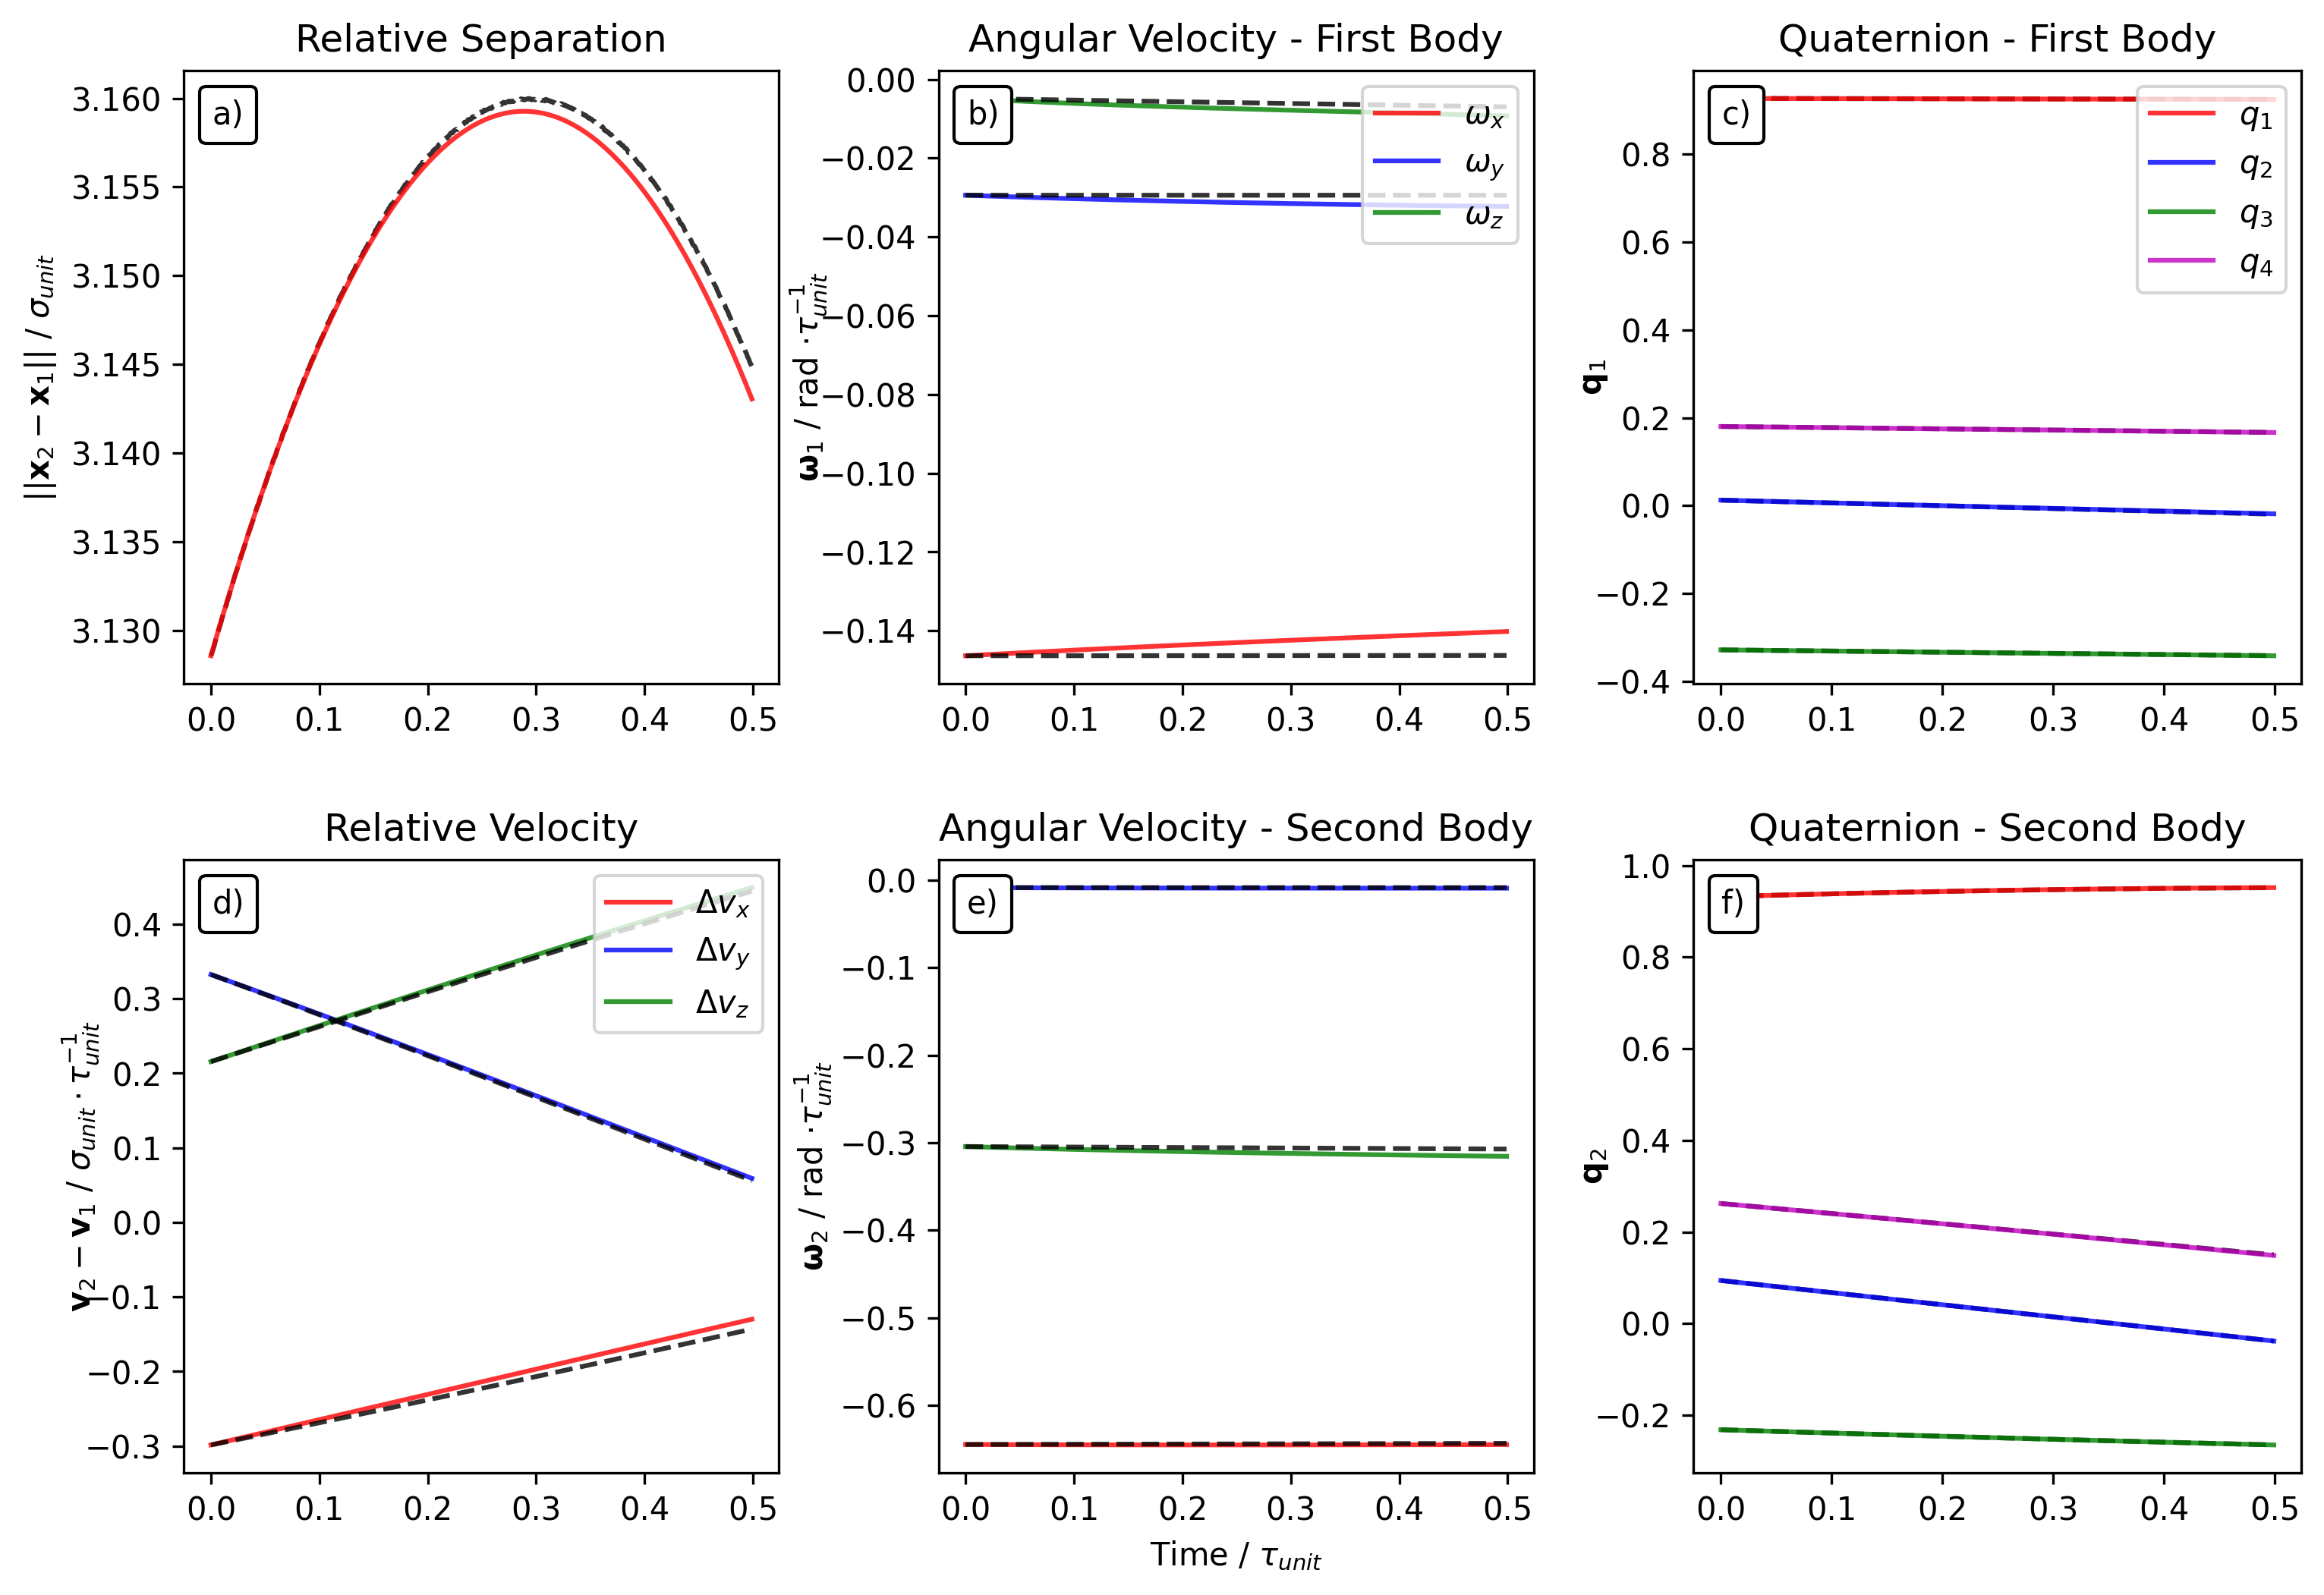

In [114]:
fig = plt.figure(figsize=(12,8), dpi=300)
axs = [0 for i in range(6)]
width = 480
height = 320
triple_width = 135
triple_width_delta = (width - 3 * triple_width) // 4
double_width = 220
double_width_delta = (width - 2 * double_width) // 2


gs = GridSpec(height, width, figure=fig)

axs[0] = fig.add_subplot(gs[:140, :triple_width])
axs[1] = fig.add_subplot(gs[:140, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
axs[2] = fig.add_subplot(gs[:140, (2*triple_width + 4*triple_width_delta):])


axs[3] = fig.add_subplot(gs[180:, :triple_width])
axs[4] = fig.add_subplot(gs[180:, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
axs[5] = fig.add_subplot(gs[180:, (2*triple_width + 4*triple_width_delta):])

# axs[6] = fig.add_subplot(gs[440:, :triple_width])
# axs[7] = fig.add_subplot(gs[440:, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
# axs[8] = fig.add_subplot(gs[440:, (2*triple_width + 4*triple_width_delta):])

sep = np.linalg.norm(batch_y[:,1,[6, 7, 8]] - batch_y[:, 0,[6, 7, 8]], axis=1).squeeze()
pred_sep = np.linalg.norm(pred_y[:,1,[6, 7, 8]] - pred_y[:, 0,[6, 7, 8]], axis=1).squeeze()
axs[0].plot(batch_t, sep, 'k--', alpha=0.8)
axs[0].plot(batch_t, pred_sep, 'r-', alpha=0.8, label='$\Delta x$')
# axs[0].legend(loc='upper right')
axs[0].set_ylabel(r'$||\mathbf{x}_2 - \mathbf{x}_1||$ / $\sigma_{unit}$')
axs[0].set_title('Relative Separation')


rel_vel = (batch_y[:,1,[0, 1, 2]] - batch_y[:, 0,[0, 1, 2]]).squeeze()
pred_rel_vel = (pred_y[:,1,[0, 1, 2]] - pred_y[:, 0,[0, 1, 2]]).squeeze()
axs[3].plot(batch_t, pred_rel_vel[:, 0], 'r-', alpha=0.8, label='$\Delta v_x$')
axs[3].plot(batch_t, pred_rel_vel[:, 1], 'b-', alpha=0.8, label='$\Delta v_y$')
axs[3].plot(batch_t, pred_rel_vel[:, 2], 'g-', alpha=0.8, label='$\Delta v_z$')
axs[3].plot(batch_t, rel_vel, 'k--', alpha=0.8)
axs[3].legend(loc='upper right')
axs[3].set_ylabel(r'$\mathbf{v}_2 - \mathbf{v}_1 $ / $\sigma_{unit} \cdot \tau_{unit}^{-1}$', labelpad=-5)
axs[3].set_title('Relative Velocity')


axs[1].plot(batch_t, pred_y[:,0,[3]].squeeze(), 'r-', alpha=0.8, label='$\omega_x$')
axs[1].plot(batch_t, pred_y[:,0,[4]].squeeze(), 'b-', alpha=0.8, label='$\omega_y$')
axs[1].plot(batch_t, pred_y[:,0,[5]].squeeze(), 'g-', alpha=0.8, label='$\omega_z$' )
axs[1].plot(batch_t, batch_y[:,0,[3, 4, 5]].squeeze(), 'k--', alpha=0.8)
axs[1].legend(loc='upper right')
axs[1].set_ylabel(r'$\mathbf{\omega}_1$ / rad $\cdot \tau^{-1}_{unit}$', labelpad=-3)
axs[1].set_title('Angular Velocity - First Body')


axs[4].plot(batch_t, pred_y[:,1,[3]].squeeze(), 'r-', alpha=0.8, label='$\omega_x$')
axs[4].plot(batch_t, pred_y[:,1,[4]].squeeze(), 'b-', alpha=0.8, label='$\omega_y$')
axs[4].plot(batch_t, pred_y[:,1,[5]].squeeze(), 'g-', alpha=0.8, label='$\omega_z$' )
axs[4].plot(batch_t, batch_y[:,1,[3, 4, 5]].squeeze(), 'k--', alpha=0.8)
# axs[4].legend(loc='upper right')
axs[4].set_ylabel(r'$\mathbf{\omega}_2$ / rad $\cdot \tau^{-1}_{unit}$', labelpad=2)
axs[4].set_title('Angular Velocity - Second Body')

axs[2].plot(batch_t, batch_y[:,0,[9, 10, 11, 12]].squeeze(), 'k--', alpha=0.8)
axs[2].plot(batch_t, pred_y[:,0,[9]].squeeze(), 'r-', alpha=0.8, label='$q_1$')
axs[2].plot(batch_t, pred_y[:,0,[10]].squeeze(), 'b-', alpha=0.8, label='$q_2$')
axs[2].plot(batch_t, pred_y[:,0,[11]].squeeze(), 'g-', alpha=0.8, label='$q_3$')
axs[2].plot(batch_t, pred_y[:,0,[12]].squeeze(), 'm-', alpha=0.8, label='$q_4$')
axs[2].set_ylabel('$\mathbf{q}_1$', labelpad=-5)
axs[2].legend(loc='upper right')
axs[2].set_title('Quaternion - First Body')

axs[5].plot(batch_t, batch_y[:,1,[9, 10, 11, 12]].squeeze(), 'k--', alpha=0.8)
axs[5].plot(batch_t, pred_y[:,1,[9]].squeeze(), 'r-', alpha=0.8, label='$q_0$')
axs[5].plot(batch_t, pred_y[:,1,[10]].squeeze(), 'b-', alpha=0.8, label='$q_1$')
axs[5].plot(batch_t, pred_y[:,1,[11]].squeeze(), 'g-', alpha=0.8, label='$q_2$')
axs[5].plot(batch_t, pred_y[:,1,[12]].squeeze(), 'm-', alpha=0.8, label='$q_3$')
# axs[5].legend(loc='upper right')
axs[5].set_ylabel('$\mathbf{q}_2$', labelpad=-5)
axs[5].set_title('Quaternion - Second Body')

axs[4].set_xlabel(r'Time / $\tau_{unit}$')


# axs[6].errorbar(traj_lengths, losses_trans, stds_trans, elinewidth=0.3, capsize=2, fmt='k', ls='none')
# axs[6].plot(traj_lengths, losses_trans, 'ro-')
# axs[6].set_title('Translational')

# axs[7].errorbar(traj_lengths, losses_rot, stds_rot, elinewidth=0.3, capsize=2, fmt='k', ls='none')
# axs[7].plot(traj_lengths, losses_rot, 'ro-')
# axs[7].set_title('Rotational')


# axs[8].set_title('Translational & Rotational')
# axs[8].errorbar(traj_lengths, losses_both, stds_both, elinewidth=0.3, capsize=2, fmt='k', ls='none')
# axs[8].plot(traj_lengths, losses_both, 'ro-')

# axs[7].set_xlabel('Trajectory Length (# of Time Steps)')
# axs[6].set_ylabel('Mean Absolute Difference')
    

# for i in range(6, 9):
#     axs[i].set_yscale('log')
# plt.setp((axs[6], axs[7], axs[8]), ylim=(4e-5, 2e1))


labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)']
# labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for i, ax in enumerate(axs):
    at = AnchoredText(
        labels[i], prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

plt.savefig('figures/hexagon_results.png')
plt.show()


Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
device = cpu
NN architecture = 11 - [64, 48, 32] - 1
number of parameters = 5489
learning rate = 0, optimizer = Adam
scheduler = LambdaLR, scheduling factor = 0.95, scheduling freq = 10
batch size = 10000, traj length = 40


<ipython-input-93-52f501ea187b>:56: RuntimeWarning: divide by zero encountered in true_divide
  return 4 * ((1.0 / (r))**12 - (1.0 / (r))**6)
<ipython-input-93-52f501ea187b>:56: RuntimeWarning: invalid value encountered in subtract
  return 4 * ((1.0 / (r))**12 - (1.0 / (r))**6)


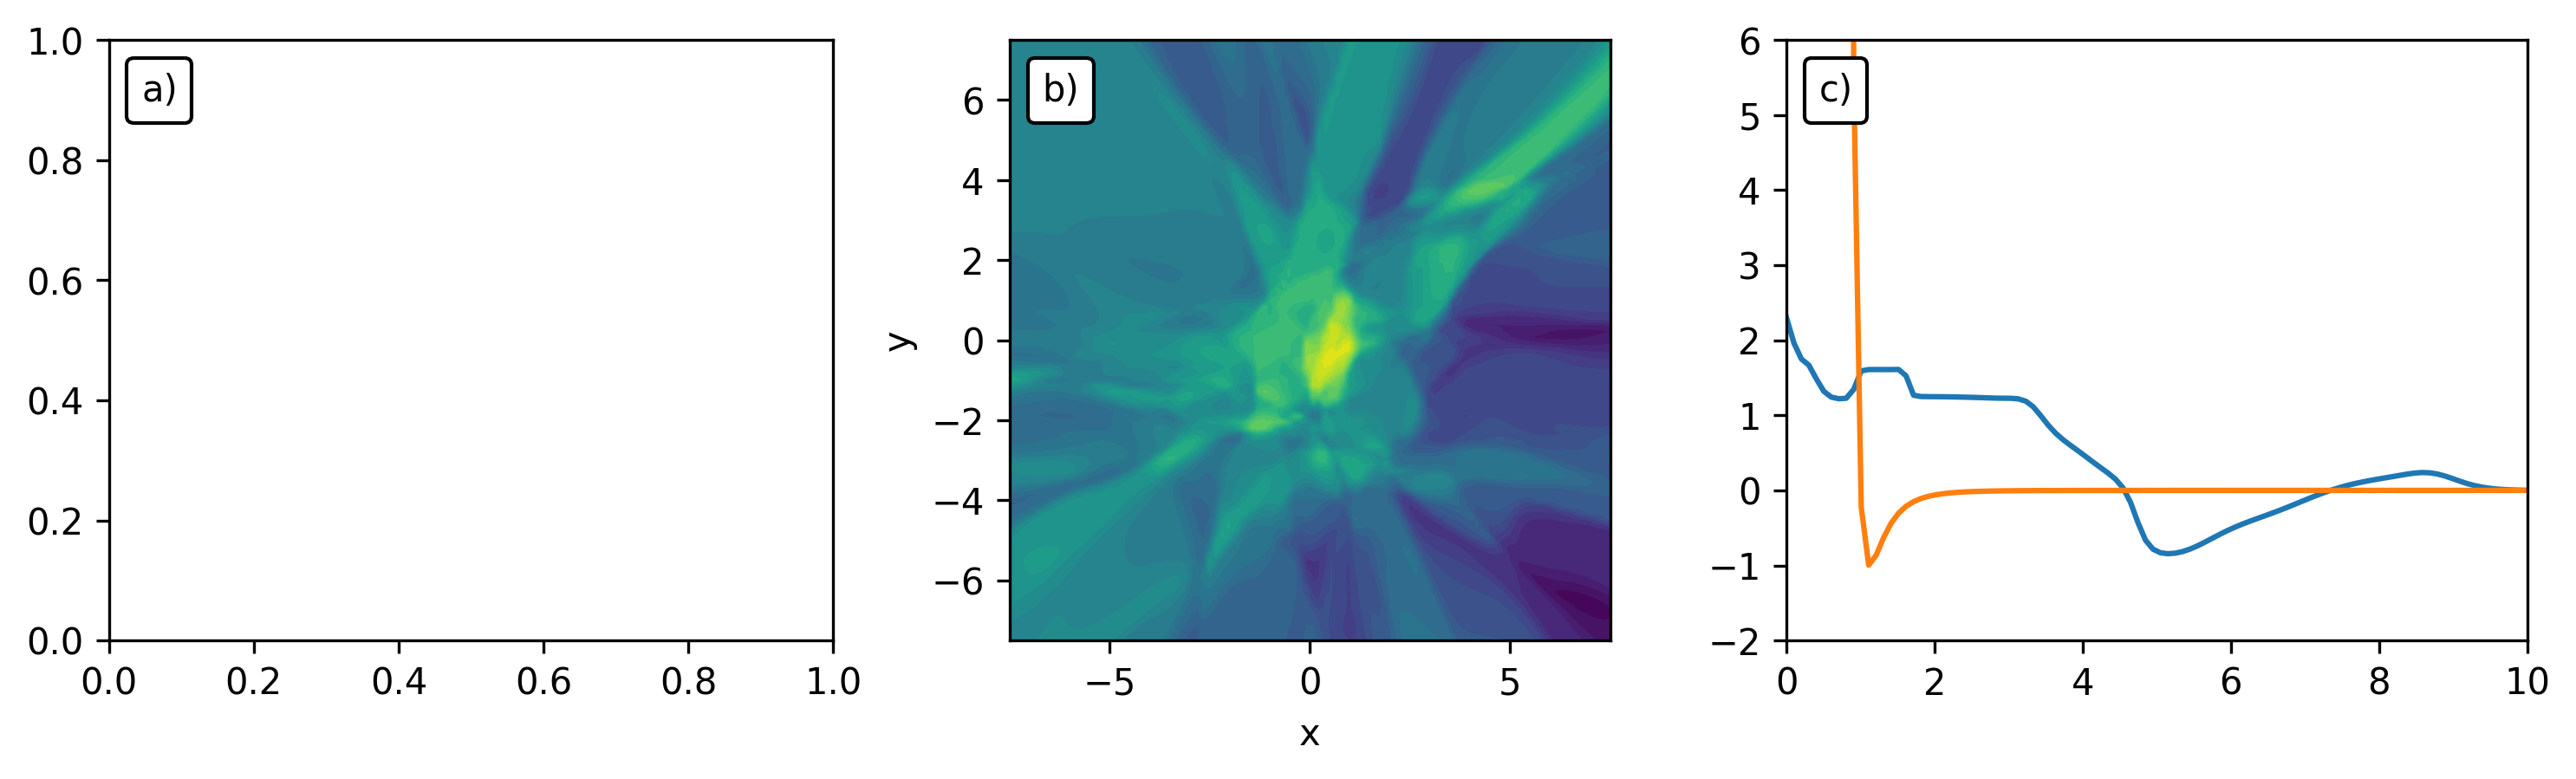

In [93]:
# Energy Side Plot
import torch
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,3), dpi=300)
axs = [0 for i in range(3)]
width = 300
height = 600
triple_width = 90
triple_width_delta = (width - 3 * triple_width) // 4
double_width = 220
double_width_delta = (width - 2 * double_width) // 2


trainer = load_trainer('results/archive/2022-08-11/12-39-15/')

gs = GridSpec(height, width, figure=fig)

axs[0] = fig.add_subplot(gs[:, :triple_width])
axs[1] = fig.add_subplot(gs[:, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
axs[2] = fig.add_subplot(gs[:, (2*triple_width + 4*triple_width_delta):])

labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)']

for i, ax in enumerate(axs):
    at = AnchoredText(
        labels[i], prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

# above contour plot
start, stop, n_values = -7.5, 7.5, 100
vals = np.linspace(start, stop, n_values)

# model
X, Y = np.meshgrid(vals, vals)
XY = np.stack([X, Y], axis=2)

Z = np.zeros((n_values, n_values))

for i in range(XY.shape[0]):
    for j in range(XY.shape[1]):
        inp = np.hstack((XY[i, j], np.array([0, 0, 0, 0, 1, 0, 0, 0, 1])))
        Z[i, j] = trainer.func.net(torch.Tensor(inp)).detach().cpu().item()
# Z -= Z.min()

# # contour plot from above
axs[1].contourf(X, Y, Z, levels=30, cmap='viridis')
# axs[1].colorbar()
axs[1].set_aspect('equal')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')


def LJ(r):
    return 4 * ((1.0 / (r))**12 - (1.0 / (r))**6)

inp = torch.zeros(11).to('cpu')
inp[6] = 1
inp[10] = 1

x_1 = torch.linspace(0, 10, 100).to('cpu')
data = []
for x in x_1:
    temp = inp.clone()
    temp[1] = x
    data.append(trainer.func.net(temp).item())
data = np.array(data)
data -= data[-1]
plt.plot(x_1.detach().numpy(), data)
plt.plot(x_1.detach().numpy(), LJ(x_1.detach().numpy()))
plt.ylim(-2, 6)
plt.xlim(0, 10)

plt.savefig('figures/potential_results.png')
plt.show()


In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(12,8), dpi=300)
axs = [0 for i in range(6)]
width = 480
height = 600
triple_width = 135
triple_width_delta = (width - 3 * triple_width) // 4
double_width = 220
double_width_delta = (width - 2 * double_width) // 2

gs = GridSpec(height, width, figure=fig)
        
axs[0] = fig.add_subplot(gs[:250, :triple_width])
axs[1] = fig.add_subplot(gs[:250, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
axs[2] = fig.add_subplot(gs[:250, (2*triple_width + 4*triple_width_delta):])

axs[3] = fig.add_subplot(gs[350:, :triple_width])
axs[4] = fig.add_subplot(gs[350:, (triple_width + 2* triple_width_delta):(2*triple_width + 2*triple_width_delta)])
axs[5] = fig.add_subplot(gs[350:, (2*triple_width + 4*triple_width_delta):])

def get_traj(i):
    trainer = load_trainer(f'results/archive/2022-08-11/12-39-15/{i}')

    with torch.no_grad():
        traj_length = 500
        start_index = 0 
        trainer.training_dataset.batch_length = traj_length
        batch_input, batch_y = trainer.training_dataset[start_index]
        batch_input = list(batch_input)
        batch_input[0] = batch_input[0].unsqueeze(0)
        batch_input = tuple(batch_input)

        pred_y = trainer.forward_pass(batch_input, batch_length=traj_length).squeeze().cpu().numpy()
        batch_y = batch_y.cpu().numpy()
        batch_t = trainer.get_batch_t(batch_input[1], batch_length=traj_length).cpu().numpy()
        return batch_t, batch_y, pred_y

def animate(i):
    batch_t, batch_y, pred_y = get_traj(i)

    for k in range(6):
        axs[k].clear()
    
    sep = np.linalg.norm(batch_y[:,1,[6, 7, 8]] - batch_y[:, 0,[6, 7, 8]], axis=1).squeeze()
    pred_sep = np.linalg.norm(pred_y[:,1,[6, 7, 8]] - pred_y[:, 0,[6, 7, 8]], axis=1).squeeze()
    
    axs[0].plot(batch_t, sep, 'k--', alpha=0.8)
    axs[0].plot(batch_t, pred_sep, 'r-', alpha=0.8, label='$\Delta x$')
    # axs[0].legend(loc='upper right')

    


    rel_vel = (batch_y[:,1,[0, 1, 2]] - batch_y[:, 0,[0, 1, 2]]).squeeze()
    pred_rel_vel = (pred_y[:,1,[0, 1, 2]] - pred_y[:, 0,[0, 1, 2]]).squeeze()
    axs[3].clear()
    axs[3].plot(batch_t, pred_rel_vel[:, 0], 'r-', alpha=0.8, label='$\Delta v_x$')
    axs[3].plot(batch_t, pred_rel_vel[:, 1], 'b-', alpha=0.8, label='$\Delta v_y$')
    axs[3].plot(batch_t, pred_rel_vel[:, 2], 'g-', alpha=0.8, label='$\Delta v_z$')
    axs[3].plot(batch_t, rel_vel, 'k--', alpha=0.8)

    axs[1].plot(batch_t, pred_y[:,0,[3]].squeeze(), 'r-', alpha=0.8, label='$\omega_x$')
    axs[1].plot(batch_t, pred_y[:,0,[4]].squeeze(), 'b-', alpha=0.8, label='$\omega_y$')
    axs[1].plot(batch_t, pred_y[:,0,[5]].squeeze(), 'g-', alpha=0.8, label='$\omega_z$' )
    axs[1].plot(batch_t, batch_y[:,0,[3, 4, 5]].squeeze(), 'k--', alpha=0.8)

    axs[4].plot(batch_t, pred_y[:,1,[3]].squeeze(), 'r-', alpha=0.8, label='$\omega_x$')
    axs[4].plot(batch_t, pred_y[:,1,[4]].squeeze(), 'b-', alpha=0.8, label='$\omega_y$')
    axs[4].plot(batch_t, pred_y[:,1,[5]].squeeze(), 'g-', alpha=0.8, label='$\omega_z$' )
    axs[4].plot(batch_t, batch_y[:,1,[3, 4, 5]].squeeze(), 'k--', alpha=0.8)
    # axs[4].legend(loc='upper right')

    axs[2].plot(batch_t, batch_y[:,0,[9, 10, 11, 12]].squeeze(), 'k--', alpha=0.8)
    axs[2].plot(batch_t, pred_y[:,0,[9]].squeeze(), 'r-', alpha=0.8, label='$q_1$')
    axs[2].plot(batch_t, pred_y[:,0,[10]].squeeze(), 'b-', alpha=0.8, label='$q_2$')
    axs[2].plot(batch_t, pred_y[:,0,[11]].squeeze(), 'g-', alpha=0.8, label='$q_3$')
    axs[2].plot(batch_t, pred_y[:,0,[12]].squeeze(), 'm-', alpha=0.8, label='$q_4$')

    axs[5].plot(batch_t, batch_y[:,1,[9, 10, 11, 12]].squeeze(), 'k--', alpha=0.8)
    axs[5].plot(batch_t, pred_y[:,1,[9]].squeeze(), 'r-', alpha=0.8, label='$q_0$')
    axs[5].plot(batch_t, pred_y[:,1,[10]].squeeze(), 'b-', alpha=0.8, label='$q_1$')
    axs[5].plot(batch_t, pred_y[:,1,[11]].squeeze(), 'g-', alpha=0.8, label='$q_2$')
    axs[5].plot(batch_t, pred_y[:,1,[12]].squeeze(), 'm-', alpha=0.8, label='$q_3$')
    # axs[5].legend(loc='upper right')

    axs[0].set_title('Relative Separation')
    axs[0].set_ylabel(r'$||\mathbf{x}_2 - \mathbf{x}_1||$ / $\sigma_{unit}$')
    axs[0].set_title('Relative Separation')
    axs[1].legend(loc='upper right')
    axs[1].set_ylabel(r'$\mathbf{\omega}_1$ / rad $\cdot \tau^{-1}_{unit}$', labelpad=-3)
    axs[1].set_title('Angular Velocity - First Body')
    axs[2].set_ylabel('$\mathbf{q}_1$', labelpad=-5)
    axs[2].legend(loc='upper right')
    axs[2].set_title('Quaternion - First Body')
    axs[3].legend(loc='upper right')
    axs[3].set_ylabel(r'$\mathbf{v}_2 - \mathbf{v}_1 $ / $\sigma_{unit} \cdot \tau_{unit}^{-1}$', labelpad=-5)
    axs[3].set_title('Relative Velocity')
    axs[4].set_ylabel(r'$\mathbf{\omega}_2$ / rad $\cdot \tau^{-1}_{unit}$', labelpad=2)
    axs[4].set_title('Angular Velocity - Second Body')
    axs[5].set_ylabel('$\mathbf{q}_2$', labelpad=-5)
    axs[5].set_title('Quaternion - Second Body')
    axs[4].set_xlabel(r'Time / $\tau_{unit}$')

    return axs


# create animation using the animate() function
anim = animation.FuncAnimation(fig, animate, frames=range(5, 11, 5), interval=10, repeat=True)

anim.save('figures/test.gif', writer = 'imagemagick', fps = 30)

Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
device = cpu
NN architecture = 11 - [64, 48, 32] - 1
number of parameters = 5489
learning rate = 0, optimizer = Adam
scheduler = LambdaLR, scheduling factor = 0.95, scheduling freq = 10
batch size = 10000, traj length = 40
Found timestep: 1e-05, n of run steps: 10000000, and dum

Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
Found timestep: 1e-05, n of run steps: 10000000, and dump log freq: 100, n of logged timesteps: 100001
crash
after crash?
device = cpu
NN architecture = 11 - [64, 48, 32] - 1
number of parameters = 5489
learning rate = 0, optimizer = Adam
scheduler = LambdaLR, scheduling factor = 0.95, scheduling freq = 10
batch size = 10000, traj length = 40


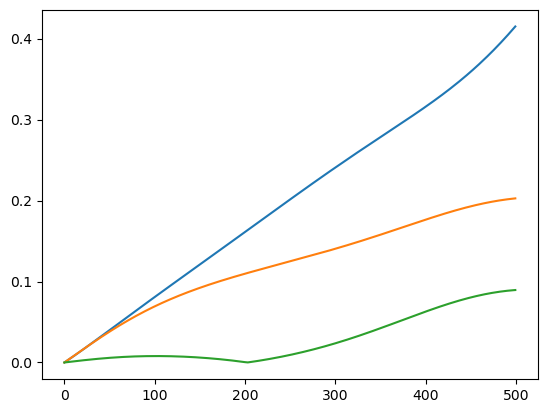

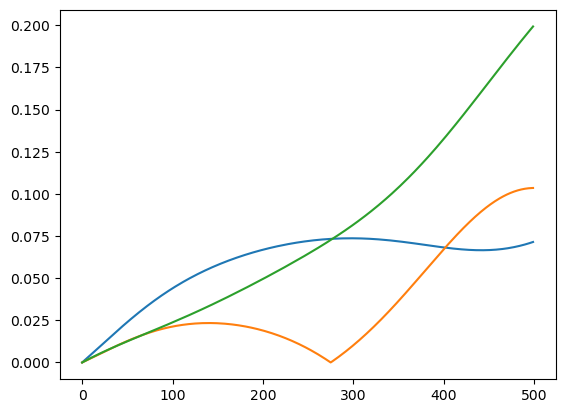

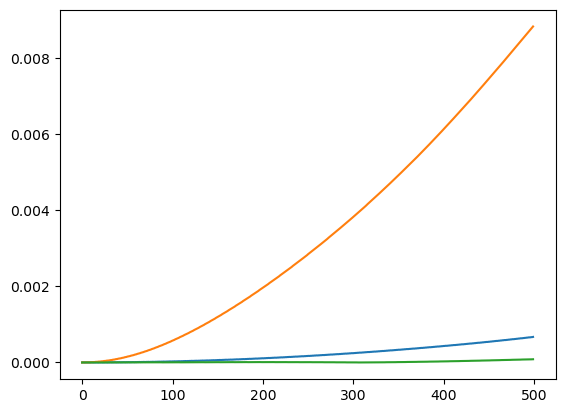

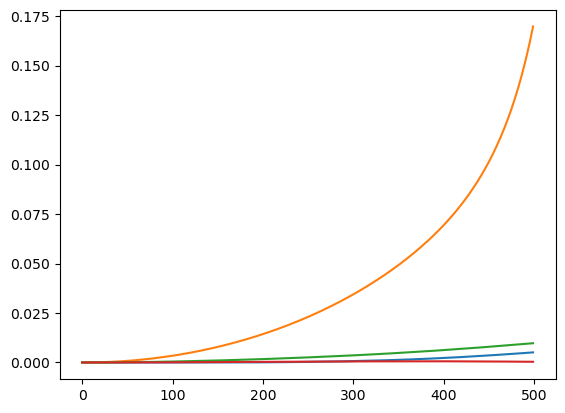

In [16]:
# Divergence
trainer = load_trainer(f'results/2022-08-23/12-56-13/100')

with torch.no_grad():
    traj_length = 500
    start_index = 0 
    trainer.training_dataset.batch_length = traj_length
    batch_input, batch_y = trainer.training_dataset[start_index]
    batch_input = list(batch_input)
    batch_input[0] = batch_input[0].unsqueeze(0)
    batch_input = tuple(batch_input)

    pred_y = trainer.forward_pass(batch_input, batch_length=traj_length).squeeze().cpu()
    batch_y = batch_y.cpu()
    batch_t = trainer.get_batch_t(batch_input[1], batch_length=traj_length).cpu()

p, l, x, q = torch.split(batch_y, [3, 3, 3, 4], dim=-1)

p_pred, l_pred, x_pred, q_pred = torch.split(pred_y, [3, 3, 3, 4], dim=-1)

delta_p = torch.abs(p_pred - p) / torch.abs(p)
delta_l = torch.abs(l_pred - l) / torch.abs(l)
delta_x = torch.abs(x_pred - x) / torch.abs(x)
delta_q = torch.abs(q_pred - q) / torch.abs(q)

plt.plot(delta_p[:, 0, :].numpy())
plt.show()

plt.plot(delta_l[:, 0, :].numpy())
plt.show()

plt.plot(delta_x[:, 0, :].numpy())
plt.show()

plt.plot(delta_q[:, 0, :].numpy())
plt.show()